In [1]:
# Solar Power Forecasting with Machine Learning and Seasonality Handling
# Comprehensive example demonstrating proper seasonality treatment in solar forecasting

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb

# Statistical and time series libraries
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import scipy.signal as signal

# Solar specific libraries
import pvlib
from pvlib import location, modelchain, pvsystem, atmosphere, clearsky

# Plotting configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ All libraries imported successfully!")
print("🌞 Solar Forecasting with ML and Seasonality Demo Ready!")

✅ All libraries imported successfully!
🌞 Solar Forecasting with ML and Seasonality Demo Ready!


# 🌞 Solar Power Forecasting with Machine Learning

## Overview
This notebook demonstrates a comprehensive approach to solar power forecasting that properly handles seasonality. We'll cover:

1. **Data Generation & Understanding** - Create realistic solar data with multiple seasonal patterns
2. **Seasonality Analysis** - Identify and quantify seasonal components
3. **Feature Engineering** - Extract time-based and astronomical features
4. **Model Development** - Compare different ML approaches
5. **Seasonality Handling** - Multiple techniques for dealing with seasonal patterns
6. **Evaluation & Validation** - Proper time series validation techniques

## Key Seasonality Challenges in Solar Forecasting
- **Annual seasonality**: Sun elevation changes throughout the year
- **Daily seasonality**: Diurnal patterns of solar irradiance
- **Weather patterns**: Seasonal cloud cover and atmospheric conditions
- **Temperature effects**: Panel efficiency variations
- **Geographic considerations**: Latitude-dependent solar angles

In [2]:
# Step 1: Generate Realistic Solar Data with Seasonality
# We'll create data for a solar farm in Southeast Asia (similar to Philippines)

def generate_solar_data(start_date='2020-01-01', end_date='2024-12-31', 
                       latitude=14.5995, longitude=120.9842, capacity_mw=100):
    """
    Generate realistic solar power data with multiple seasonal patterns
    Location: Philippines (Manila area)
    """
    # Create datetime index with hourly frequency
    date_range = pd.date_range(start=start_date, end=end_date, freq='h')
    
    # Initialize location for solar calculations
    site = location.Location(latitude, longitude, tz='Asia/Manila')
    
    # Calculate solar position and clear-sky irradiance
    solar_position = site.get_solarposition(date_range)
    clear_sky = site.get_clearsky(date_range)
    
    # Create DataFrame
    df = pd.DataFrame(index=date_range)
    df['ghi'] = clear_sky['ghi']  # Global Horizontal Irradiance
    df['dni'] = clear_sky['dni']  # Direct Normal Irradiance
    df['dhi'] = clear_sky['dhi']  # Diffuse Horizontal Irradiance
    df['solar_elevation'] = solar_position['elevation']
    df['solar_azimuth'] = solar_position['azimuth']
    
    # Add time-based features
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['day_of_year'] = df.index.dayofyear
    df['week'] = df.index.isocalendar().week
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
    
    # Add seasonal patterns
    # 1. Annual seasonality (due to sun elevation changes)
    annual_factor = 0.9 + 0.2 * np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    
    # 2. Monsoon seasonality (Philippines has wet/dry seasons)
    # Wet season: June-November, Dry season: December-May
    monsoon_factor = np.where(
        (df['month'] >= 6) & (df['month'] <= 11),
        0.7 + 0.2 * np.random.random(len(df)),  # Wet season - more clouds
        0.95 + 0.1 * np.random.random(len(df))  # Dry season - clearer skies
    )
    
    # 3. Temperature effect on panel efficiency
    # Assume temperature varies with season and time of day
    temp_base = 25 + 5 * np.sin(2 * np.pi * df['day_of_year'] / 365.25)  # Annual temp variation
    temp_daily = 8 * np.sin(2 * np.pi * df['hour'] / 24 - np.pi/2)  # Daily temp variation
    temperature = temp_base + temp_daily + np.random.normal(0, 2, len(df))
    
    # Temperature coefficient for silicon panels (-0.4%/°C)
    temp_factor = 1 - 0.004 * (temperature - 25)
    
    # 4. Random weather events (clouds, rain)
    weather_noise = np.random.lognormal(0, 0.3, len(df))
    weather_noise = np.clip(weather_noise, 0.1, 2.0)
    
    # Calculate actual irradiance considering all factors
    df['irradiance'] = (df['ghi'] * annual_factor * monsoon_factor * 
                       weather_noise * np.clip(temp_factor, 0.7, 1.2))
    
    # Ensure nighttime values are zero
    df['irradiance'] = np.where(df['solar_elevation'] > 0, df['irradiance'], 0)
    
    # Convert to power output (MW)
    # Assume panel efficiency of 20% and performance ratio of 0.85
    df['power_mw'] = (df['irradiance'] * capacity_mw * 0.20 * 0.85) / 1000
    df['power_mw'] = np.clip(df['power_mw'], 0, capacity_mw)
    
    # Add temperature data
    df['temperature'] = temperature
    
    return df

# Generate the data
print("🔄 Generating realistic solar data...")
solar_data = generate_solar_data()

print(f"✅ Generated {len(solar_data):,} hourly records from {solar_data.index[0]} to {solar_data.index[-1]}")
print(f"📊 Data shape: {solar_data.shape}")
print(f"🌞 Average power output: {solar_data['power_mw'].mean():.2f} MW")
print(f"⚡ Peak power output: {solar_data['power_mw'].max():.2f} MW")

# Display first few rows
solar_data.head()

🔄 Generating realistic solar data...
✅ Generated 43,825 hourly records from 2020-01-01 00:00:00 to 2024-12-31 00:00:00
📊 Data shape: (43825, 15)
🌞 Average power output: 4.06 MW
⚡ Peak power output: 37.30 MW


,ghi,dni,dhi,solar_elevation,solar_azimuth,year,month,day,hour,day_of_year,week,is_weekend,irradiance,power_mw,temperature
2020-01-01 00:00:00,289.990756,608.663688,76.945970,20.444237,121.942503,2020,1,1,0,1,1,0,183.631929,3.121743,16.697380
2020-01-01 01:00:00,505.724789,760.699385,99.855827,32.218928,129.980067,2020,1,1,1,1,1,0,435.918111,7.410608,16.834851
2020-01-01 02:00:00,674.529136,831.895200,113.643489,42.375734,141.758824,2020,1,1,2,1,1,0,495.745759,8.427678,18.931818
2020-01-01 03:00:00,781.025986,865.259853,121.383460,49.658760,158.705231,2020,1,1,3,1,1,0,524.392591,8.914674,19.568313
2020-01-01 04:00:00,816.829608,875.037271,123.868240,52.352561,180.290897,2020,1,1,4,1,1,0,810.131145,13.772229,21.503271


<Axes: title={'center': 'power_mw'}, xlabel='month'>

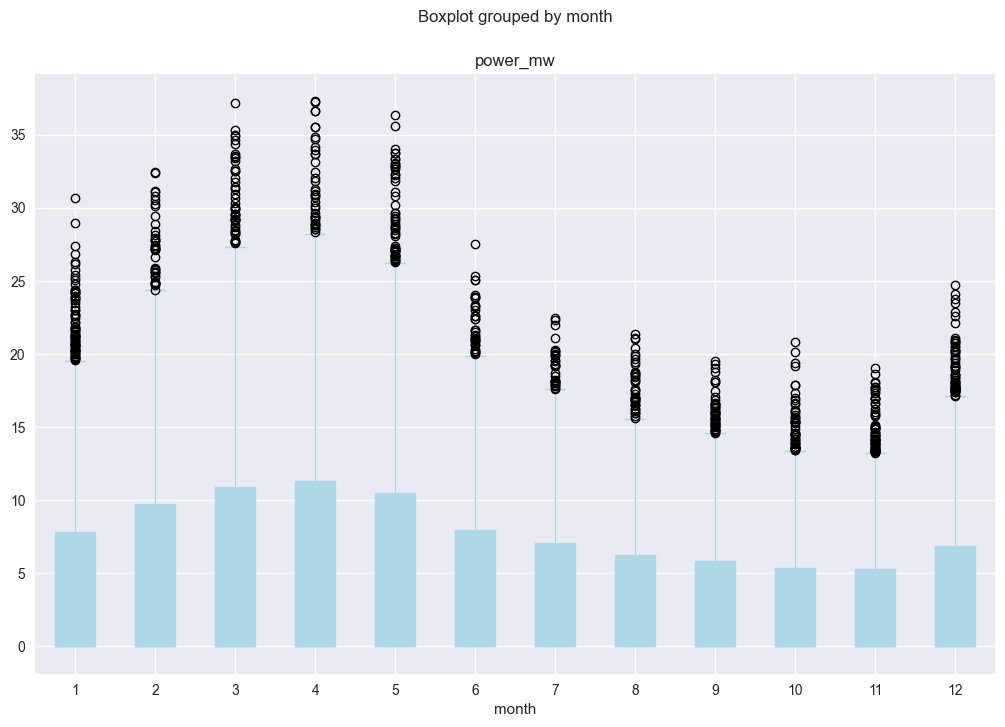

In [3]:
solar_data1 = solar_data.copy()
solar_data1['month'] = solar_data1.index.month
solar_data1.boxplot(column='power_mw', by='month', patch_artist=True, color='lightblue')

In [4]:
solar_data.groupby(solar_data.index.date).mean().head()

,ghi,dni,dhi,solar_elevation,solar_azimuth,year,month,day,hour,day_of_year,week,is_weekend,irradiance,power_mw,temperature
2020-01-01,226.059348,310.497380,41.969878,-8.455683,180.009655,2020.0,1.0,1.0,11.5,1.0,1.0,0.0,202.372055,3.440325,25.325854
2020-01-02,226.560689,311.229703,41.912022,-8.436888,180.011702,2020.0,1.0,2.0,11.5,2.0,1.0,0.0,206.314195,3.507341,25.278622
2020-01-03,227.093684,311.979488,41.856482,-8.416253,180.013946,2020.0,1.0,3.0,11.5,3.0,1.0,0.0,225.746029,3.837682,25.877991
2020-01-04,227.657972,312.746320,41.803193,-8.393772,180.016422,2020.0,1.0,4.0,11.5,4.0,1.0,1.0,224.127673,3.810170,25.239215
2020-01-05,228.253158,313.529769,41.752085,-8.369437,180.019169,2020.0,1.0,5.0,11.5,5.0,1.0,1.0,202.611923,3.444403,25.896140


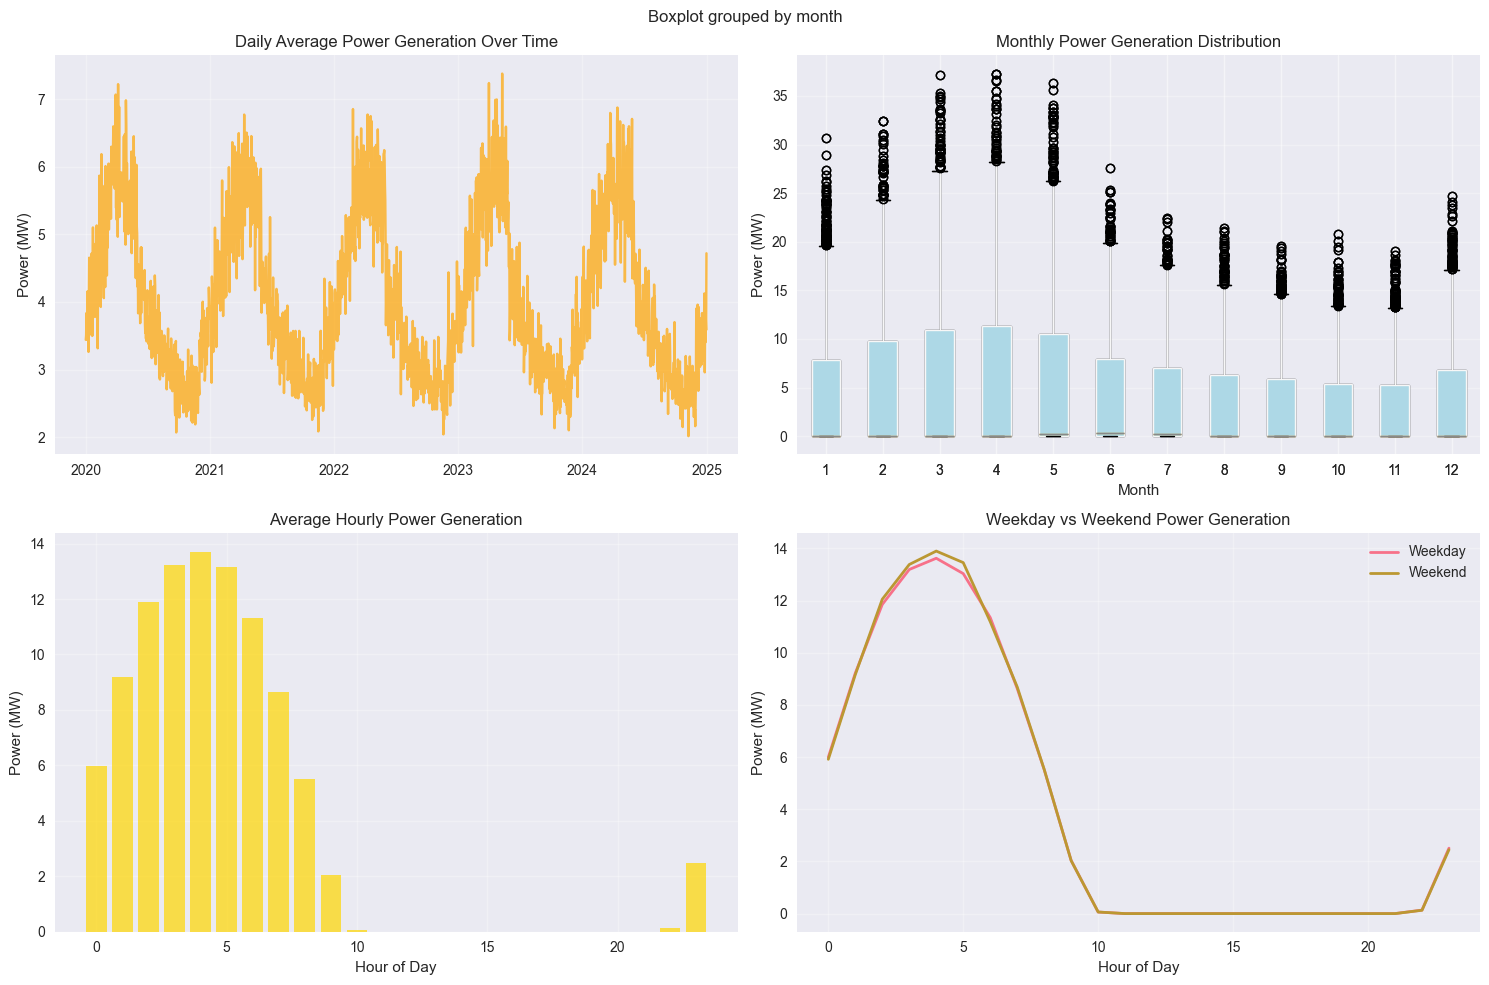

📈 KEY SEASONALITY INSIGHTS:
🌞 Peak generation month: 4 (avg: 5.78 MW)
🌧️ Lowest generation month: 11 (avg: 2.70 MW)
⏰ Peak generation hour: 4:00 (avg: 13.70 MW)
📊 Seasonal variation: 113.7% difference


In [7]:
# Step 2: Visualize the Data and Understand Seasonality Patterns

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Solar Power Generation Patterns', fontsize=16, fontweight='bold')

# Plot 1: Annual power generation pattern
daily_avg = solar_data.groupby(solar_data.index.date)['power_mw'].mean()
daily_avg.index = pd.to_datetime(daily_avg.index)
axes[0, 0].plot(daily_avg.index, daily_avg.values, alpha=0.7, color='orange')
axes[0, 0].set_title('Daily Average Power Generation Over Time')
axes[0, 0].set_ylabel('Power (MW)')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Monthly boxplot
monthly_data = solar_data.groupby('month')['power_mw'].apply(list).reset_index()
monthly_power = [solar_data[solar_data['month'] == i]['power_mw'].values for i in range(1, 13)]
bp = axes[0, 1].boxplot(monthly_power, labels=range(1, 13), patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
bp = solar_data.boxplot(column='power_mw', by='month', ax=axes[0, 1], patch_artist=True)
for patch in bp.patches:#['boxes']:
    patch.set_facecolor('lightblue')
axes[0, 1].set_title('Monthly Power Generation Distribution')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Power (MW)')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Hourly pattern
hourly_avg = solar_data.groupby('hour')['power_mw'].mean()
axes[1, 0].bar(hourly_avg.index, hourly_avg.values, color='gold', alpha=0.7)
axes[1, 0].set_title('Average Hourly Power Generation')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Power (MW)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Weekend vs weekday comparison
weekend_avg = solar_data[solar_data['is_weekend'] == 1].groupby('hour')['power_mw'].mean()
weekday_avg = solar_data[solar_data['is_weekend'] == 0].groupby('hour')['power_mw'].mean()
axes[1, 1].plot(weekday_avg.index, weekday_avg.values, label='Weekday', linewidth=2)
axes[1, 1].plot(weekend_avg.index, weekend_avg.values, label='Weekend', linewidth=2)
axes[1, 1].set_title('Weekday vs Weekend Power Generation')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Power (MW)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some key statistics
print("📈 KEY SEASONALITY INSIGHTS:")
print(f"🌞 Peak generation month: {solar_data.groupby('month')['power_mw'].mean().idxmax()} (avg: {solar_data.groupby('month')['power_mw'].mean().max():.2f} MW)")
print(f"🌧️ Lowest generation month: {solar_data.groupby('month')['power_mw'].mean().idxmin()} (avg: {solar_data.groupby('month')['power_mw'].mean().min():.2f} MW)")
print(f"⏰ Peak generation hour: {solar_data.groupby('hour')['power_mw'].mean().idxmax()}:00 (avg: {solar_data.groupby('hour')['power_mw'].mean().max():.2f} MW)")
print(f"📊 Seasonal variation: {(solar_data.groupby('month')['power_mw'].mean().max() / solar_data.groupby('month')['power_mw'].mean().min() - 1) * 100:.1f}% difference")

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

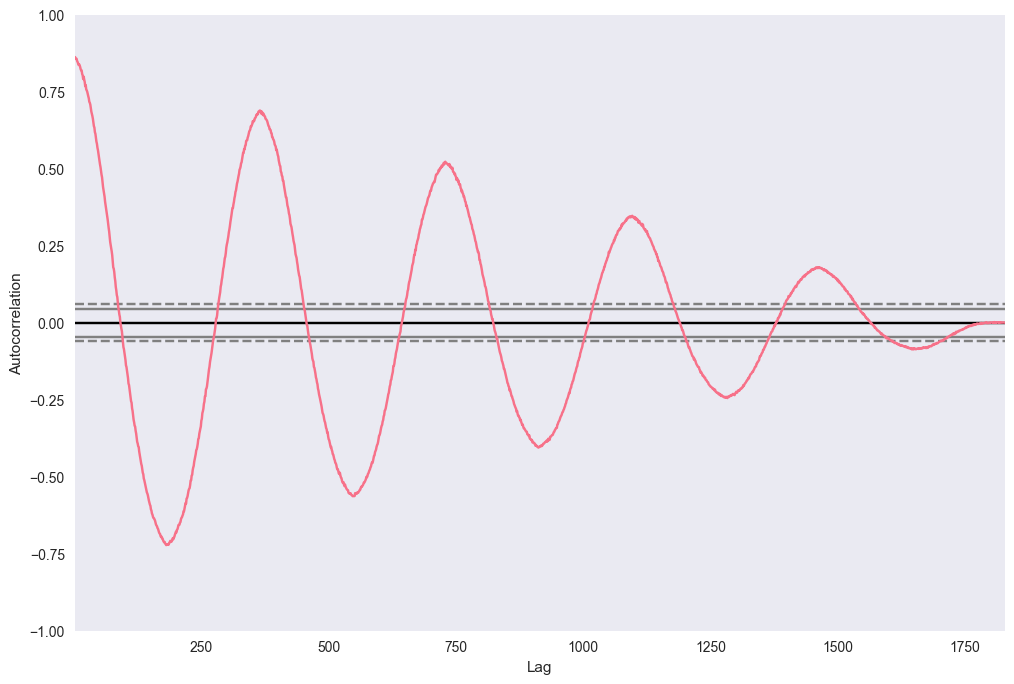

In [8]:
from pandas.plotting import autocorrelation_plot  
daily_power = solar_data.resample('D')['power_mw'].sum()
autocorrelation_plot(daily_power)  

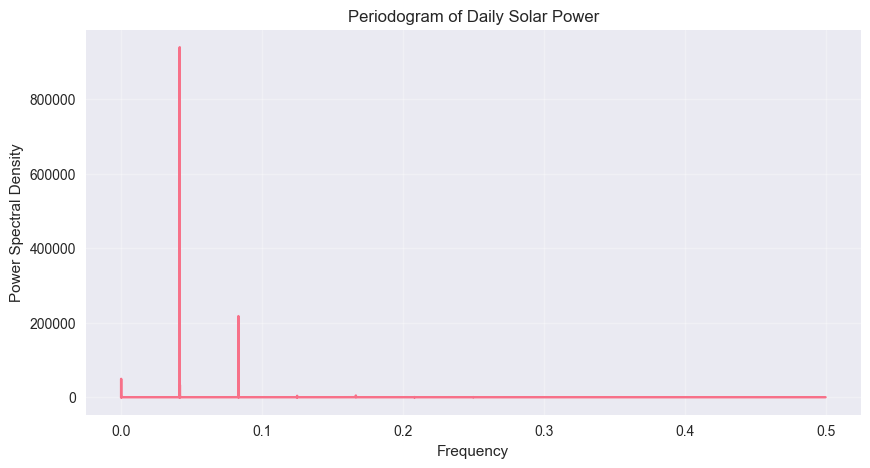

In [9]:
from scipy.signal import periodogram  
f, Pxx = periodogram(solar_data['power_mw'])  
# The period is 1/f where Pxx is maximized (excluding f=0)  
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(f, Pxx)
ax.set_xlabel('Frequency')
ax.set_ylabel('Power Spectral Density')
ax.set_title('Periodogram of Daily Solar Power')
ax.grid(True, alpha=0.3)
plt.show()

In [10]:
fa=f[Pxx.argsort()[-3:]]
[1/x for x in fa]

[8765.0, 12.00027382256298, 24.00054764512596]

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import periodogram

🔍 STEP 3: FORMAL SEASONALITY DECOMPOSITION


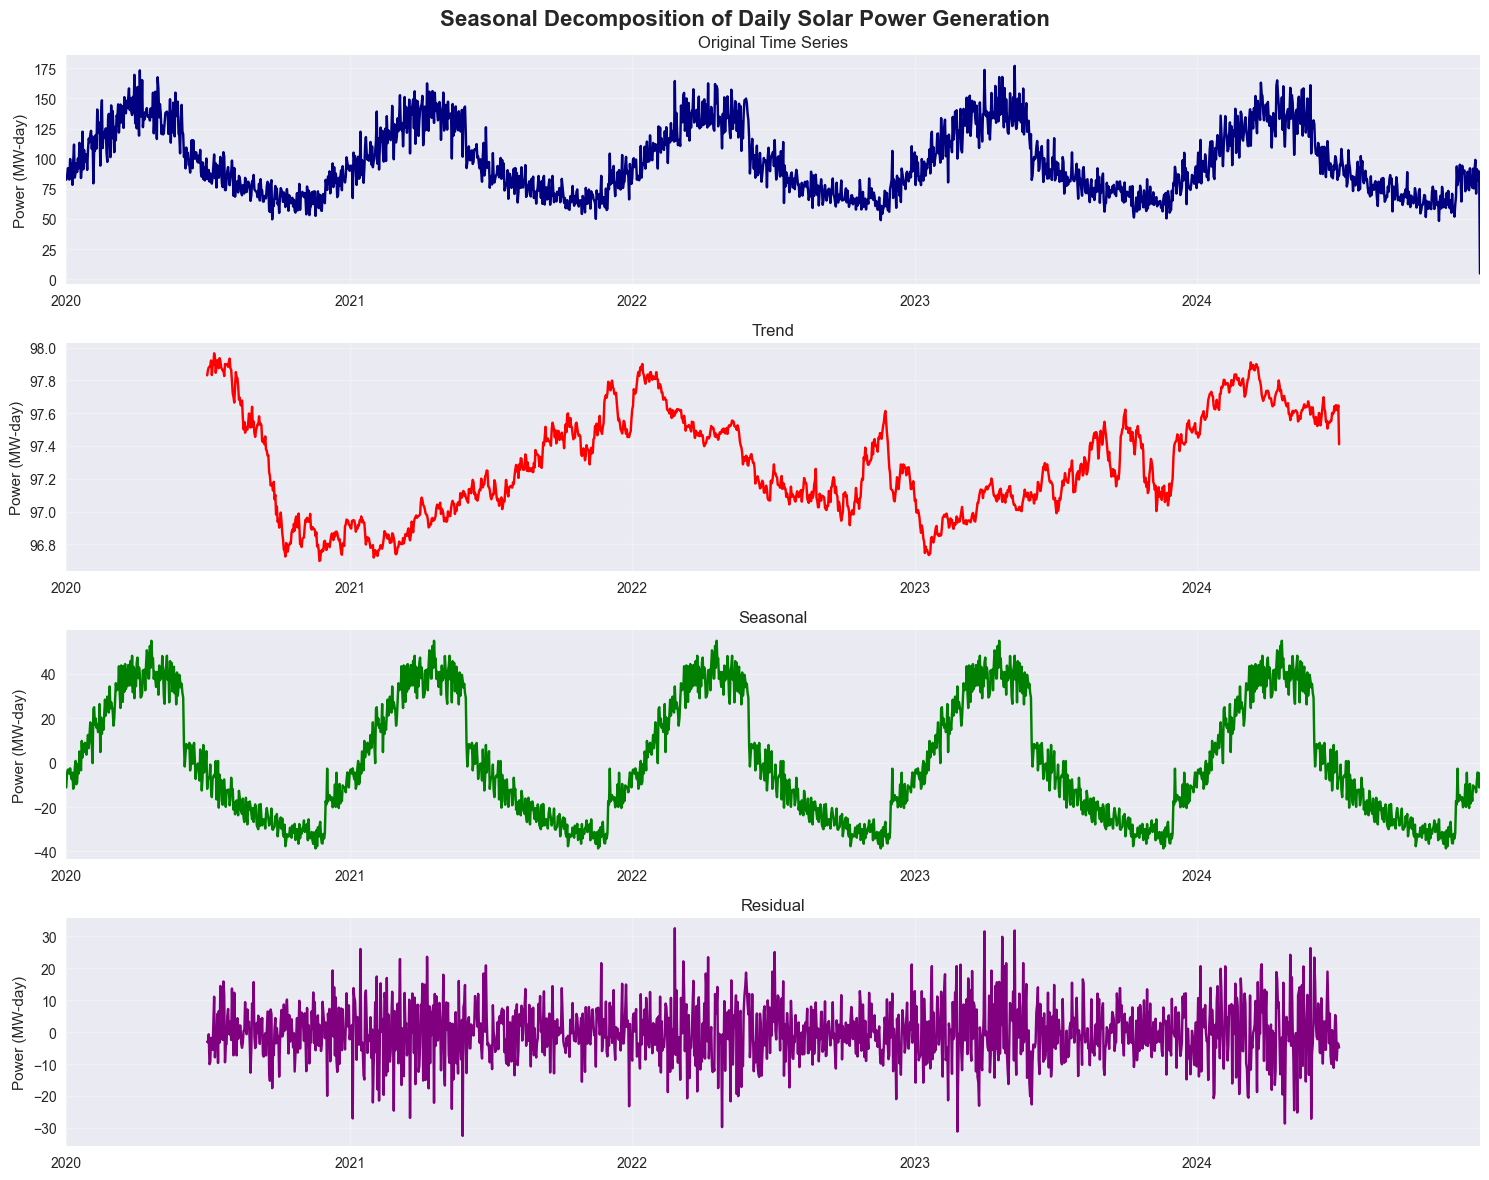

📊 Seasonal Strength: 0.901 (0 = no seasonality, 1 = perfect seasonality)
📈 Trend Strength: 0.001 (0 = no trend, 1 = perfect trend)

🔄 MULTIPLE SEASONALITY ANALYSIS:
Weekly variation: 1.9%
Monthly variation: 113.7%
Hourly variation: inf%


In [12]:
# Step 3: Formal Seasonality Decomposition
print("🔍 STEP 3: FORMAL SEASONALITY DECOMPOSITION")

# Prepare daily aggregated data for decomposition
daily_power = solar_data.resample('D')['power_mw'].sum()

# Perform seasonal decomposition
decomposition = seasonal_decompose(daily_power, model='additive', period=365)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12))
fig.suptitle('Seasonal Decomposition of Daily Solar Power Generation', fontsize=16, fontweight='bold')

decomposition.observed.plot(ax=axes[0], title='Original Time Series', color='navy')
decomposition.trend.plot(ax=axes[1], title='Trend', color='red')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal', color='green')
decomposition.resid.plot(ax=axes[3], title='Residual', color='purple')

for ax in axes:
    ax.grid(True, alpha=0.3)
    ax.set_ylabel('Power (MW-day)')

plt.tight_layout()
plt.show()

# Calculate seasonality strength
seasonal_strength = 1 - (np.var(decomposition.resid.dropna()) / np.var((decomposition.resid+decomposition.seasonal).dropna()))
trend_strength = 1 - (np.var(decomposition.resid.dropna()) / np.var((decomposition.resid+decomposition.trend).dropna()))

print(f"📊 Seasonal Strength: {seasonal_strength:.3f} (0 = no seasonality, 1 = perfect seasonality)")
print(f"📈 Trend Strength: {trend_strength:.3f} (0 = no trend, 1 = perfect trend)")

# Analyze seasonal patterns by frequency
print("\n🔄 MULTIPLE SEASONALITY ANALYSIS:")

# Weekly seasonality
weekly_pattern = solar_data.groupby(solar_data.index.dayofweek)['power_mw'].mean()
print(f"Weekly variation: {(weekly_pattern.max() / weekly_pattern.min() - 1) * 100:.1f}%")

# Monthly seasonality  
monthly_pattern = solar_data.groupby('month')['power_mw'].mean()
print(f"Monthly variation: {(monthly_pattern.max() / monthly_pattern.min() - 1) * 100:.1f}%")

# Hourly seasonality
hourly_pattern = solar_data.groupby('hour')['power_mw'].mean()
print(f"Hourly variation: {(hourly_pattern.max() / hourly_pattern.min() - 1) * 100:.1f}%")

In [14]:
# Step 4: Advanced Feature Engineering for Seasonality
print("🔧 STEP 4: ADVANCED FEATURE ENGINEERING")

def create_seasonal_features(df):
    """
    Create comprehensive features to capture seasonality patterns
    """
    df_features = df.copy()
    
    # 1. Cyclical encoding for time features (sine/cosine transformations)
    # This preserves the cyclical nature of time (e.g., Dec is close to Jan)
    
    # Hour of day (24-hour cycle)
    df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
    df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
    
    # Day of year (365-day cycle)
    df_features['day_of_year_sin'] = np.sin(2 * np.pi * df_features['day_of_year'] / 365.25)
    df_features['day_of_year_cos'] = np.cos(2 * np.pi * df_features['day_of_year'] / 365.25)
    
    # Month (12-month cycle)
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
    
    # Day of week (7-day cycle)
    df_features['dayofweek'] = df_features.index.dayofweek
    df_features['dayofweek_sin'] = np.sin(2 * np.pi * df_features['dayofweek'] / 7)
    df_features['dayofweek_cos'] = np.cos(2 * np.pi * df_features['dayofweek'] / 7)
    
    # 2. Solar-specific features
    # Solar elevation is crucial for solar power generation
    df_features['solar_elevation_positive'] = np.maximum(df_features['solar_elevation'], 0)
    
    # Solar radiation components
    df_features['ghi_norm'] = df_features['ghi'] / (df_features['ghi'].max() + 1e-6)
    df_features['dni_norm'] = df_features['dni'] / (df_features['dni'].max() + 1e-6)
    df_features['dhi_norm'] = df_features['dhi'] / (df_features['dhi'].max() + 1e-6)
    
    # 3. Weather and atmospheric features
    df_features['temp_deviation'] = df_features['temperature'] - df_features['temperature'].rolling(24*7).mean()
    df_features['temp_squared'] = df_features['temperature'] ** 2
    
    # 4. Lag features (capturing temporal dependencies)
    # Previous day same hour
    df_features['power_lag_24h'] = df_features['power_mw'].shift(24)
    # Previous week same hour
    df_features['power_lag_168h'] = df_features['power_mw'].shift(168)
    
    # Rolling statistics
    df_features['power_rolling_mean_24h'] = df_features['power_mw'].rolling(24, min_periods=1).mean()
    df_features['power_rolling_std_24h'] = df_features['power_mw'].rolling(24, min_periods=1).std()
    df_features['power_rolling_mean_168h'] = df_features['power_mw'].rolling(168, min_periods=1).mean()
    
    # 5. Interaction features
    df_features['hour_month_interaction'] = df_features['hour_sin'] * df_features['month_sin']
    df_features['solar_temp_interaction'] = df_features['solar_elevation_positive'] * df_features['temperature']
    
    # 6. Seasonal indicators
    df_features['is_dry_season'] = ((df_features['month'] <= 5) | (df_features['month'] == 12)).astype(int)
    df_features['is_peak_sun_hours'] = ((df_features['hour'] >= 9) & (df_features['hour'] <= 15)).astype(int)
    
    return df_features

# Create features
solar_features = create_seasonal_features(solar_data)

print(f"✅ Feature engineering complete!")
print(f"📊 Original features: {solar_data.shape[1]}")
print(f"🔧 Total features after engineering: {solar_features.shape[1]}")
print(f"🆕 New features added: {solar_features.shape[1] - solar_data.shape[1]}")

# Display new features
new_features = [col for col in solar_features.columns if col not in solar_data.columns]
print(f"\n🎯 NEW FEATURES CREATED:")
for i, feature in enumerate(new_features, 1):
    print(f"{i:2d}. {feature}")

# Show correlation with target variable
feature_correlations = solar_features[new_features + ['power_mw']].corr()['power_mw'].sort_values(ascending=False)
print(f"\n📈 TOP 10 FEATURES BY CORRELATION WITH POWER OUTPUT:")
print(feature_correlations.head(11)[1:])  # Exclude power_mw itself

🔧 STEP 4: ADVANCED FEATURE ENGINEERING
✅ Feature engineering complete!
📊 Original features: 15
🔧 Total features after engineering: 39
🆕 New features added: 24

🎯 NEW FEATURES CREATED:
 1. hour_sin
 2. hour_cos
 3. day_of_year_sin
 4. day_of_year_cos
 5. month_sin
 6. month_cos
 7. dayofweek
 8. dayofweek_sin
 9. dayofweek_cos
10. solar_elevation_positive
11. ghi_norm
12. dni_norm
13. dhi_norm
14. temp_deviation
15. temp_squared
16. power_lag_24h
17. power_lag_168h
18. power_rolling_mean_24h
19. power_rolling_std_24h
20. power_rolling_mean_168h
21. hour_month_interaction
22. solar_temp_interaction
23. is_dry_season
24. is_peak_sun_hours

📈 TOP 10 FEATURES BY CORRELATION WITH POWER OUTPUT:
ghi_norm                    0.894446
solar_temp_interaction      0.893819
solar_elevation_positive    0.882553
power_lag_24h               0.873608
power_lag_168h              0.872950
dni_norm                    0.861240
dhi_norm                    0.852248
hour_sin                    0.677585
hour_co

In [15]:
# Step 5: Machine Learning Models with Seasonality Handling
print("🤖 STEP 5: MACHINE LEARNING MODELS")

# Prepare data for modeling
# Remove rows with NaN values (due to lag features)
modeling_data = solar_features.dropna()

# Select features for modeling
feature_columns = [
    # Cyclical time features
    'hour_sin', 'hour_cos', 'day_of_year_sin', 'day_of_year_cos', 
    'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos',
    
    # Solar and weather features
    'solar_elevation_positive', 'ghi_norm', 'dni_norm', 'dhi_norm',
    'temperature', 'temp_deviation', 'temp_squared',
    
    # Lag features
    'power_lag_24h', 'power_lag_168h', 
    'power_rolling_mean_24h', 'power_rolling_std_24h', 'power_rolling_mean_168h',
    
    # Interaction features
    'hour_month_interaction', 'solar_temp_interaction',
    
    # Seasonal indicators
    'is_dry_season', 'is_peak_sun_hours', 'is_weekend'
]

X = modeling_data[feature_columns]
y = modeling_data['power_mw']

print(f"📊 Modeling dataset shape: {X.shape}")
print(f"🎯 Target variable: {y.name}")
print(f"📅 Date range: {modeling_data.index[0]} to {modeling_data.index[-1]}")

# Time series split for proper validation
# We'll use 80% for training and 20% for testing, maintaining temporal order
split_date = modeling_data.index[int(len(modeling_data) * 0.8)]
train_mask = modeling_data.index <= split_date
test_mask = modeling_data.index > split_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"\n📈 Training period: {X_train.index[0]} to {X_train.index[-1]} ({len(X_train):,} samples)")
print(f"📉 Testing period: {X_test.index[0]} to {X_test.index[-1]} ({len(X_test):,} samples)")

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1)
}

# Train and evaluate models
results = {}
predictions = {}

print(f"\n🚀 Training {len(models)} models...")
for name, model in models.items():
    print(f"  🔄 Training {name}...")
    
    # Train model
    start_time = datetime.now()
    model.fit(X_train, y_train)
    training_time = (datetime.now() - start_time).total_seconds()
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results[name] = {
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'training_time': training_time
    }
    
    predictions[name] = {
        'train': y_pred_train,
        'test': y_pred_test
    }
    
    print(f"    ✅ {name}: Test MAE = {test_mae:.3f} MW, Test R² = {test_r2:.3f}")

# Create results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.round(3)

print(f"\n📊 MODEL PERFORMANCE COMPARISON:")
print(results_df[['test_mae', 'test_rmse', 'test_r2', 'training_time']].sort_values('test_mae'))

🤖 STEP 5: MACHINE LEARNING MODELS
📊 Modeling dataset shape: (43657, 25)
🎯 Target variable: power_mw
📅 Date range: 2020-01-08 00:00:00 to 2024-12-31 00:00:00

📈 Training period: 2020-01-08 00:00:00 to 2024-01-02 05:00:00 (34,926 samples)
📉 Testing period: 2024-01-02 06:00:00 to 2024-12-31 00:00:00 (8,731 samples)

🚀 Training 5 models...
  🔄 Training Linear Regression...
    ✅ Linear Regression: Test MAE = 1.266 MW, Test R² = 0.869
  🔄 Training Random Forest...
    ✅ Random Forest: Test MAE = 0.939 MW, Test R² = 0.887
  🔄 Training Gradient Boosting...
    ✅ Gradient Boosting: Test MAE = 0.941 MW, Test R² = 0.890
  🔄 Training XGBoost...
    ✅ XGBoost: Test MAE = 0.976 MW, Test R² = 0.878
  🔄 Training LightGBM...
    ✅ LightGBM: Test MAE = 0.928 MW, Test R² = 0.890

📊 MODEL PERFORMANCE COMPARISON:
                   test_mae  test_rmse  test_r2  training_time
LightGBM              0.928      1.953    0.890          0.226
Random Forest         0.939      1.982    0.887          3.034
Gradie

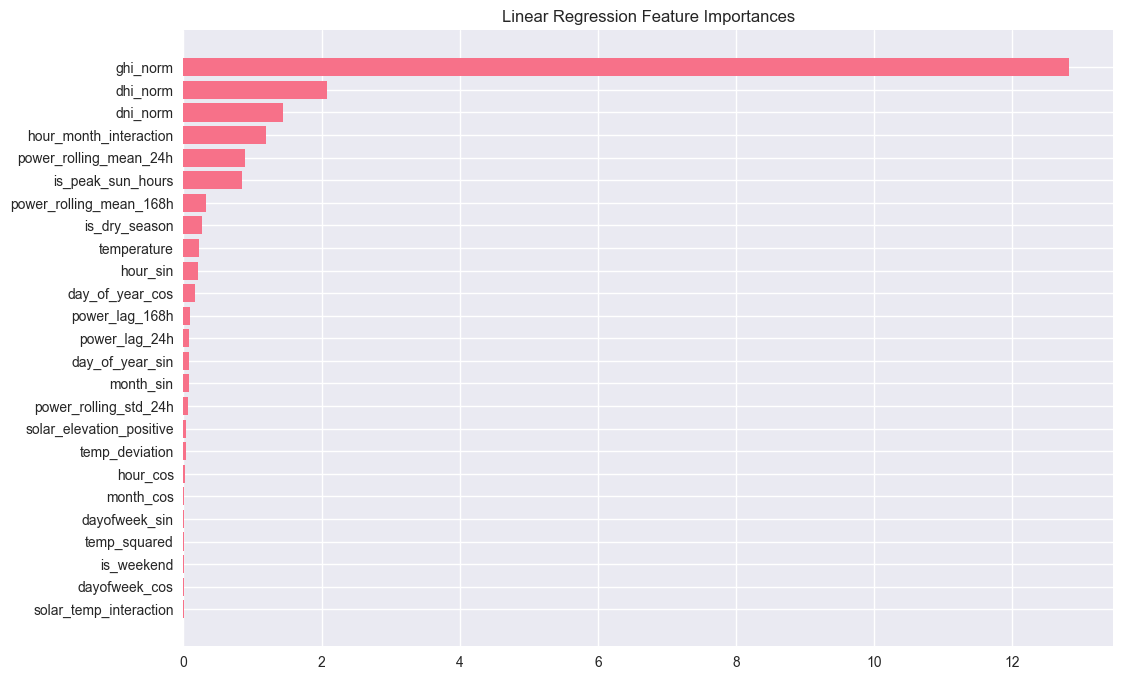

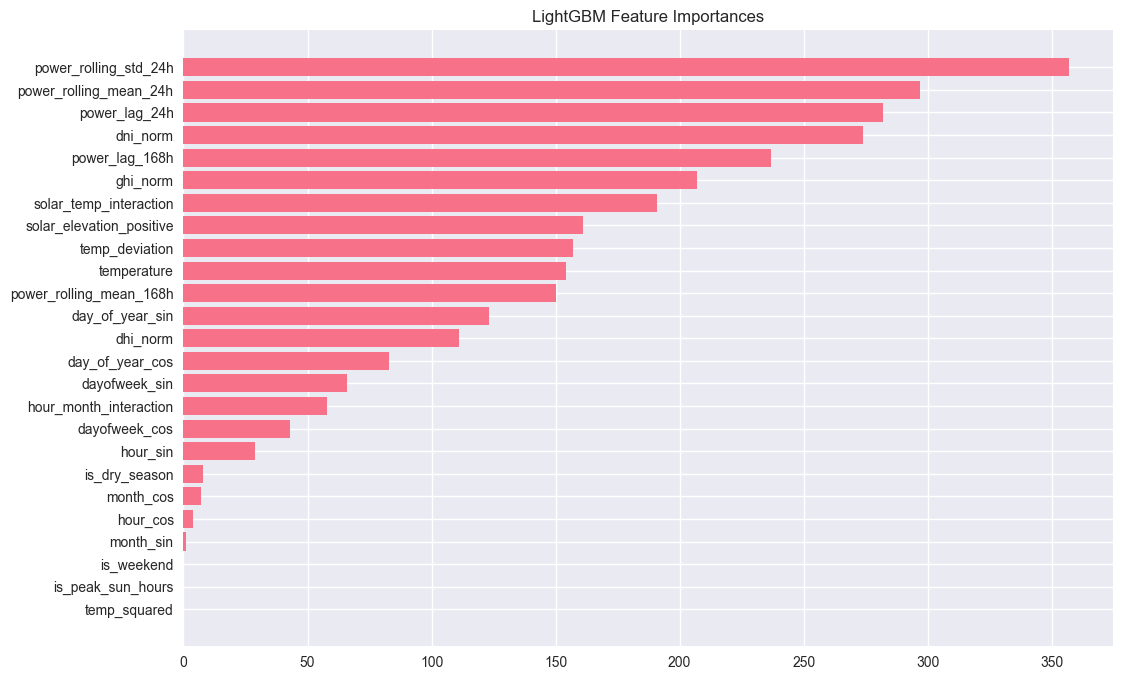

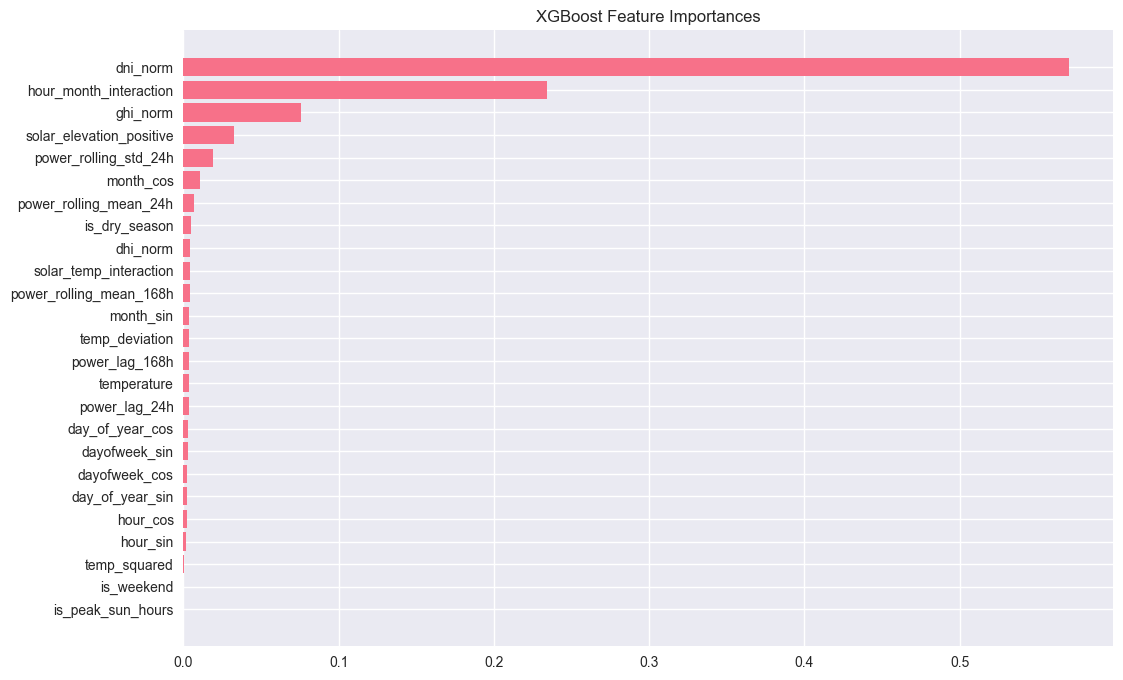

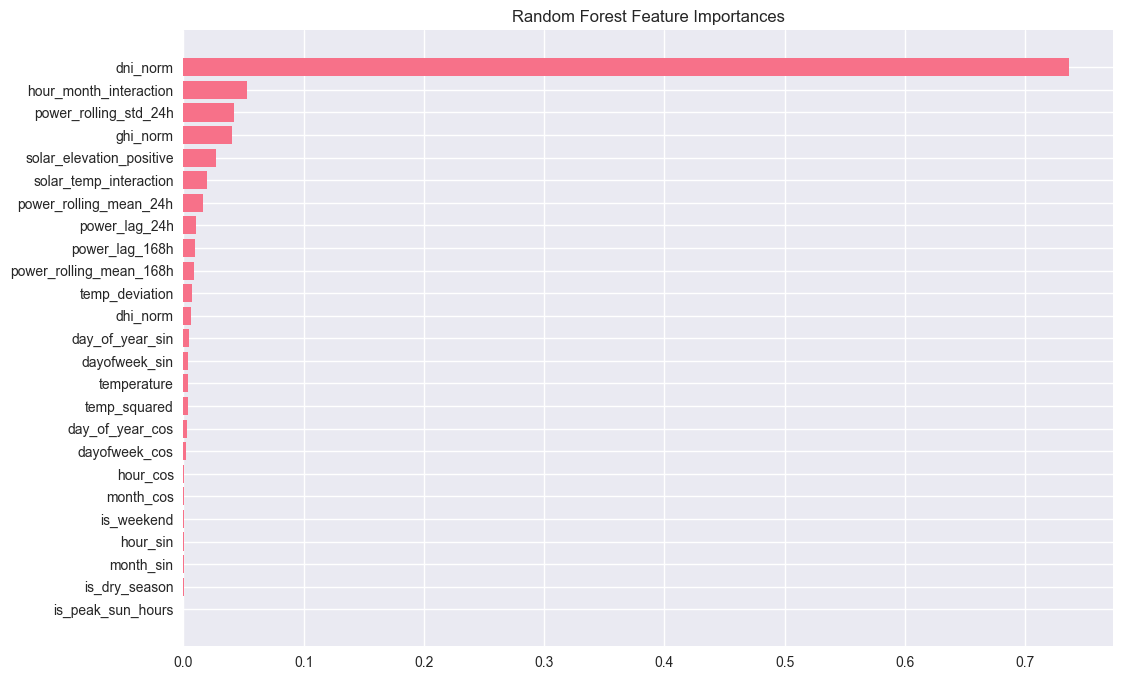

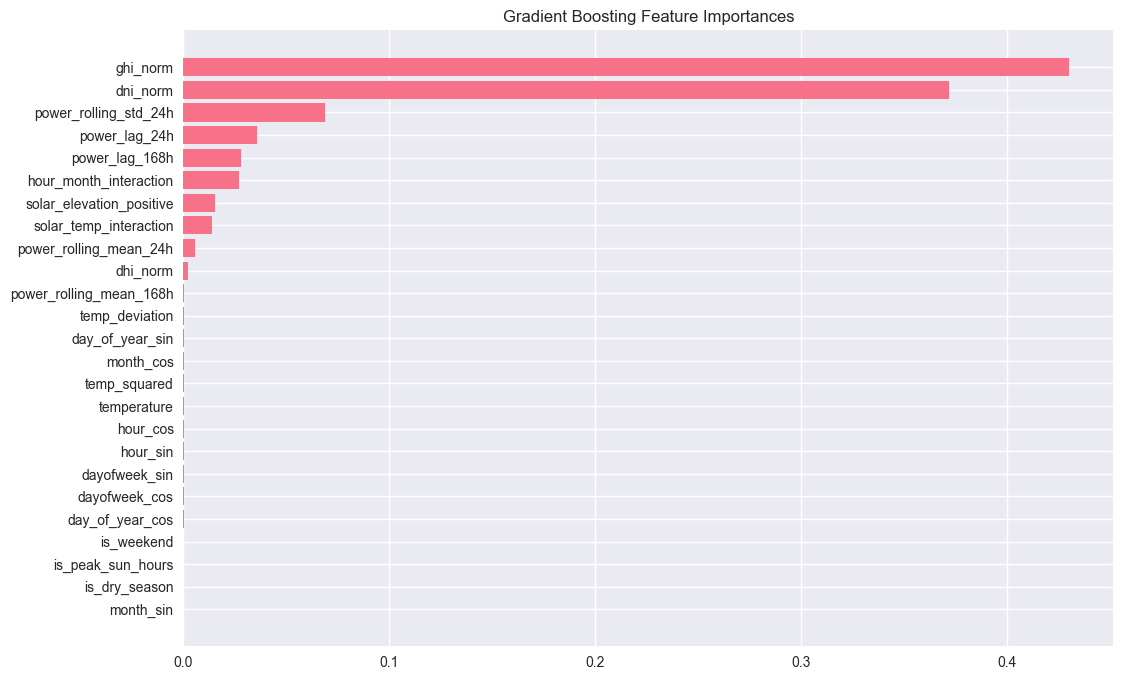

In [42]:
# Feature importance analysis
for model_name in ['Linear Regression', 'LightGBM', 'XGBoost', 'Random Forest', 'Gradient Boosting']:
    model = models[model_name]
    if model_name == 'Linear Regression':
        ft_importances = list(zip(model.feature_names_in_, np.abs(model.coef_)))
    else:
        ft_importances = list(zip(model.feature_names_in_, model.feature_importances_))
    ft_importances = sorted(ft_importances, key=lambda x: x[1], reverse=False)
    plt.barh([x[0] for x in ft_importances], [x[1] for x in ft_importances])
    plt.title(model_name + ' Feature Importances')
    plt.show()

📈 STEP 6: MODEL PERFORMANCE & SEASONALITY ANALYSIS
🏆 Best Model: LightGBM
📊 Test MAE: 0.928 MW
📊 Test R²: 0.890


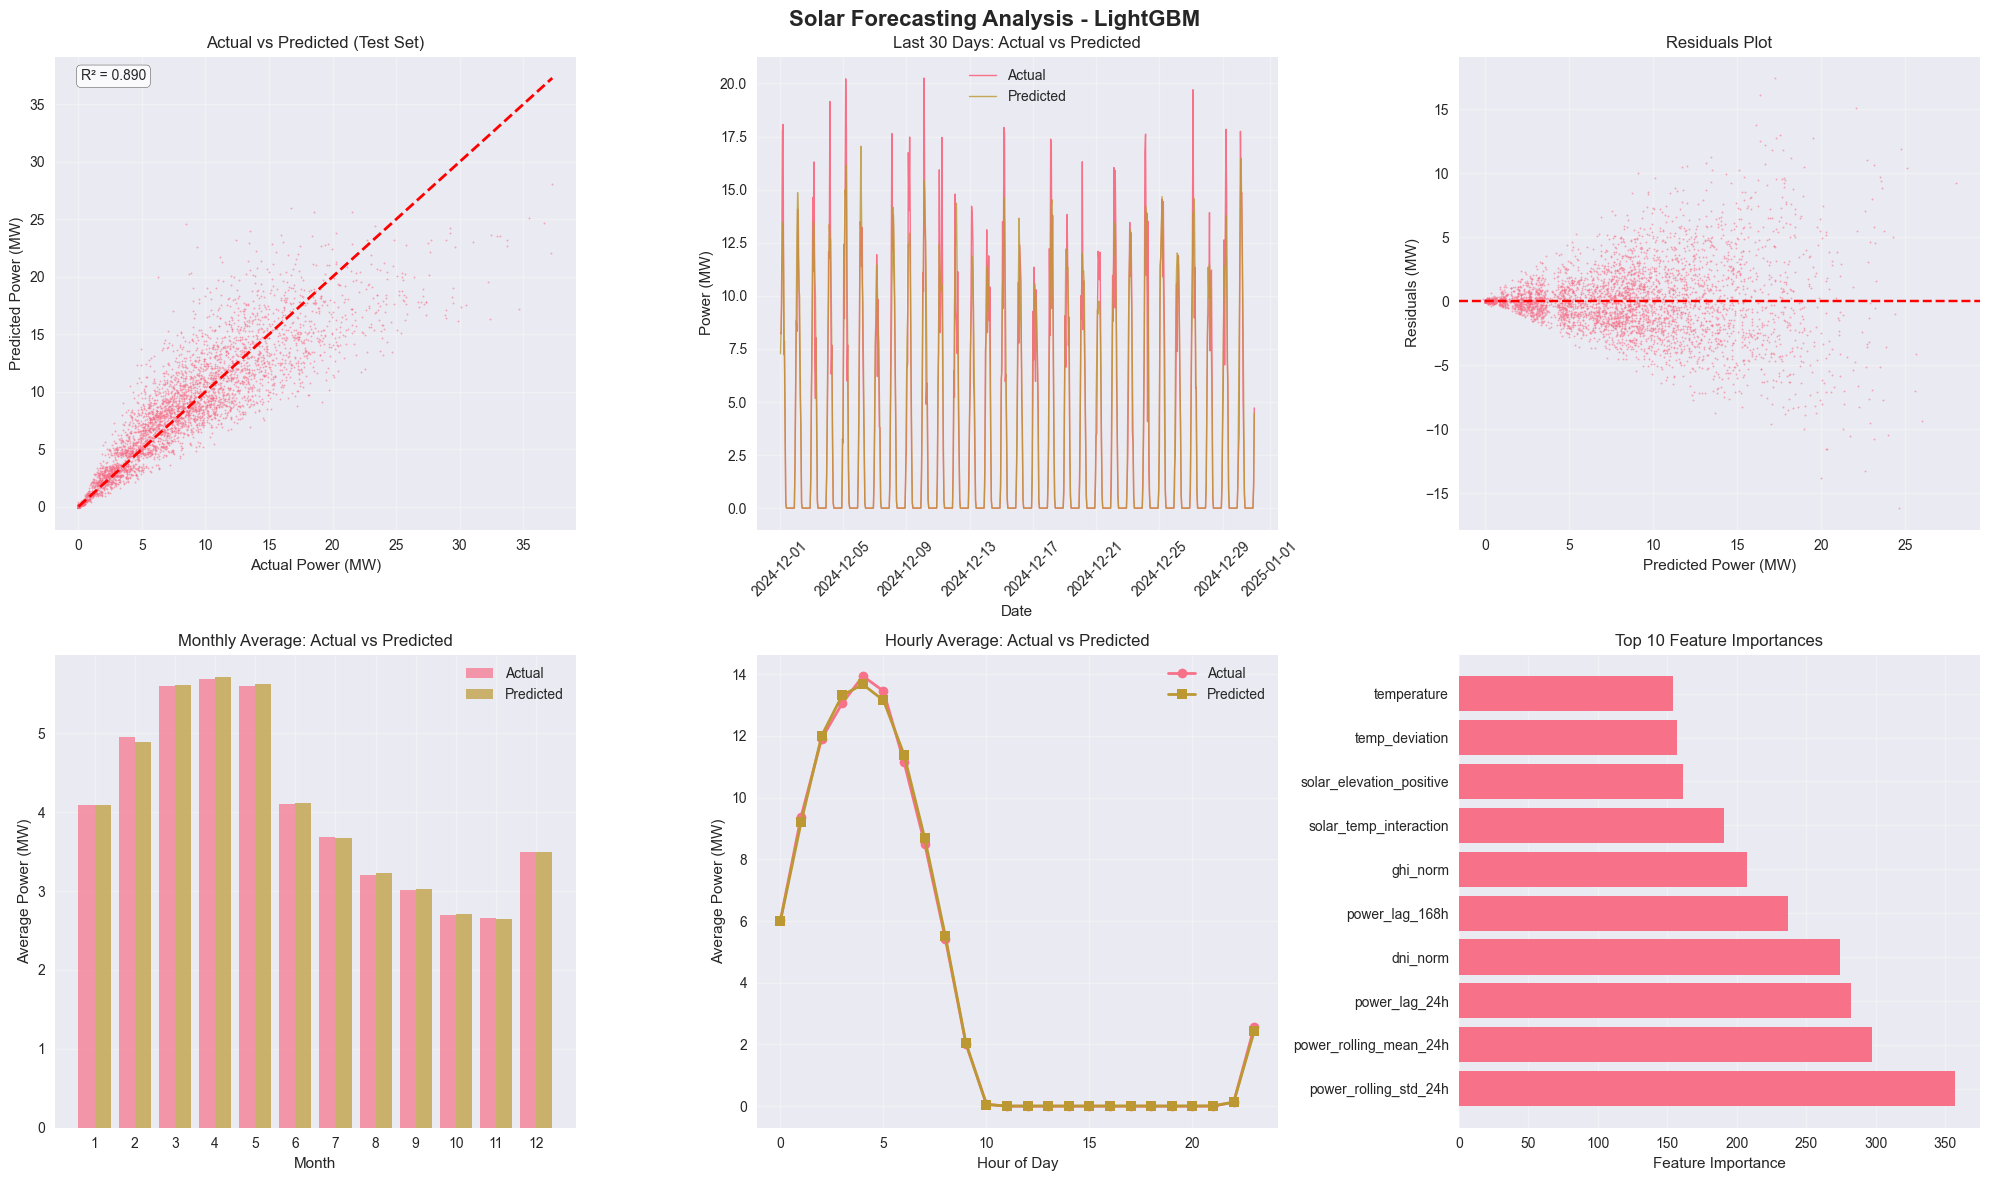


🌍 SEASONAL PERFORMANCE ANALYSIS:
📅 Monthly MAE (MW):
    January: 0.979
   February: 1.122
      March: 1.324
      April: 1.304
        May: 1.245
       June: 0.887
       July: 0.844
     August: 0.707
  September: 0.694
    October: 0.622
   November: 0.620
   December: 0.789

🏆 Best performing month: November (MAE: 0.620 MW)
🚨 Challenging month: March (MAE: 1.324 MW)
📊 Seasonal variation in MAE: 113.5%


In [43]:
# Step 6: Analyze Model Performance and Seasonality Handling
print("📈 STEP 6: MODEL PERFORMANCE & SEASONALITY ANALYSIS")

# Select best model for detailed analysis
best_model_name = results_df.sort_values('test_mae').index[0]
best_model = models[best_model_name]
best_predictions = predictions[best_model_name]

print(f"🏆 Best Model: {best_model_name}")
print(f"📊 Test MAE: {results_df.loc[best_model_name, 'test_mae']:.3f} MW")
print(f"📊 Test R²: {results_df.loc[best_model_name, 'test_r2']:.3f}")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle(f'Solar Forecasting Analysis - {best_model_name}', fontsize=16, fontweight='bold')

# Plot 1: Actual vs Predicted (Test Set)
axes[0, 0].scatter(y_test, best_predictions['test'], alpha=0.5, s=1)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Power (MW)')
axes[0, 0].set_ylabel('Predicted Power (MW)')
axes[0, 0].set_title('Actual vs Predicted (Test Set)')
axes[0, 0].grid(True, alpha=0.3)

# Calculate and display R² on the plot
r2_test = r2_score(y_test, best_predictions['test'])
axes[0, 0].text(0.05, 0.95, f'R² = {r2_test:.3f}', transform=axes[0, 0].transAxes, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Time Series Prediction (Last 30 days)
last_30_days = y_test.tail(30*24)  # Last 30 days of hourly data
pred_30_days = pd.Series(best_predictions['test'], index=y_test.index).tail(30*24)

axes[0, 1].plot(last_30_days.index, last_30_days.values, label='Actual', linewidth=1)
axes[0, 1].plot(pred_30_days.index, pred_30_days.values, label='Predicted', linewidth=1, alpha=0.8)
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Power (MW)')
axes[0, 1].set_title('Last 30 Days: Actual vs Predicted')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Residuals Analysis
residuals = y_test - best_predictions['test']
axes[0, 2].scatter(best_predictions['test'], residuals, alpha=0.5, s=1)
axes[0, 2].axhline(y=0, color='r', linestyle='--')
axes[0, 2].set_xlabel('Predicted Power (MW)')
axes[0, 2].set_ylabel('Residuals (MW)')
axes[0, 2].set_title('Residuals Plot')
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Seasonal Performance - Monthly
test_data_with_pred = pd.DataFrame({
    'actual': y_test,
    'predicted': best_predictions['test'],
    'month': y_test.index.month
})

monthly_performance = test_data_with_pred.groupby('month').agg({
    'actual': 'mean',
    'predicted': 'mean'
}).reset_index()

x_months = monthly_performance['month']
axes[1, 0].bar(x_months - 0.2, monthly_performance['actual'], width=0.4, label='Actual', alpha=0.7)
axes[1, 0].bar(x_months + 0.2, monthly_performance['predicted'], width=0.4, label='Predicted', alpha=0.7)
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Power (MW)')
axes[1, 0].set_title('Monthly Average: Actual vs Predicted')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(range(1, 13))

# Plot 5: Hourly Performance
hourly_performance = test_data_with_pred.groupby(test_data_with_pred.index.hour).agg({
    'actual': 'mean',
    'predicted': 'mean'
}).reset_index()

axes[1, 1].plot(hourly_performance.index, hourly_performance['actual'], 'o-', label='Actual', linewidth=2)
axes[1, 1].plot(hourly_performance.index, hourly_performance['predicted'], 's-', label='Predicted', linewidth=2)
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Average Power (MW)')
axes[1, 1].set_title('Hourly Average: Actual vs Predicted')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Feature Importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    axes[1, 2].barh(range(len(importance_df)), importance_df['importance'])
    axes[1, 2].set_yticks(range(len(importance_df)))
    axes[1, 2].set_yticklabels(importance_df['feature'])
    axes[1, 2].set_xlabel('Feature Importance')
    axes[1, 2].set_title('Top 10 Feature Importances')
    axes[1, 2].grid(True, alpha=0.3)
else:
    # For linear models, show coefficient magnitudes
    if hasattr(best_model, 'coef_'):
        coef_df = pd.DataFrame({
            'feature': feature_columns,
            'coefficient': np.abs(best_model.coef_)
        }).sort_values('coefficient', ascending=False).head(10)
        
        axes[1, 2].barh(range(len(coef_df)), coef_df['coefficient'])
        axes[1, 2].set_yticks(range(len(coef_df)))
        axes[1, 2].set_yticklabels(coef_df['feature'])
        axes[1, 2].set_xlabel('|Coefficient|')
        axes[1, 2].set_title('Top 10 Feature Coefficients')
        axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate seasonal performance metrics
print(f"\n🌍 SEASONAL PERFORMANCE ANALYSIS:")
seasonal_mae = test_data_with_pred.groupby('month').apply(
    lambda x: mean_absolute_error(x['actual'], x['predicted'])
).round(3)

print("📅 Monthly MAE (MW):")
for month, mae in seasonal_mae.items():
    month_name = pd.to_datetime(f'2024-{month:02d}-01').strftime('%B')
    print(f"  {month_name:>9}: {mae:.3f}")

best_month = seasonal_mae.idxmin()
worst_month = seasonal_mae.idxmax()
print(f"\n🏆 Best performing month: {pd.to_datetime(f'2024-{best_month:02d}-01').strftime('%B')} (MAE: {seasonal_mae[best_month]:.3f} MW)")
print(f"🚨 Challenging month: {pd.to_datetime(f'2024-{worst_month:02d}-01').strftime('%B')} (MAE: {seasonal_mae[worst_month]:.3f} MW)")
print(f"📊 Seasonal variation in MAE: {((seasonal_mae.max() / seasonal_mae.min() - 1) * 100):.1f}%")

In [44]:
# Step 7: Multi-Horizon Forecasting (1-6 Hours Ahead)
print("🔮 STEP 7: MULTI-HORIZON FORECASTING (1-6 HOURS AHEAD)")

def create_multi_horizon_targets(df, horizons=[1, 2, 3, 4, 5, 6]):
    """
    Create target variables for multiple forecast horizons
    """
    df_targets = df.copy()
    
    for h in horizons:
        df_targets[f'power_mw_h{h}'] = df_targets['power_mw'].shift(-h)
    
    return df_targets

def create_multi_horizon_features(df, max_horizon=6):
    """
    Enhanced feature engineering for multi-horizon forecasting
    """
    df_features = df.copy()
    
    # 1. Cyclical encoding for time features
    df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
    df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
    df_features['day_of_year_sin'] = np.sin(2 * np.pi * df_features['day_of_year'] / 365.25)
    df_features['day_of_year_cos'] = np.cos(2 * np.pi * df_features['day_of_year'] / 365.25)
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
    
    df_features['dayofweek'] = df_features.index.dayofweek
    df_features['dayofweek_sin'] = np.sin(2 * np.pi * df_features['dayofweek'] / 7)
    df_features['dayofweek_cos'] = np.cos(2 * np.pi * df_features['dayofweek'] / 7)
    
    # 2. Future time features (for the forecast horizon)
    for h in range(1, max_horizon + 1):
        future_hour = (df_features['hour'] + h) % 24
        df_features[f'future_hour_sin_h{h}'] = np.sin(2 * np.pi * future_hour / 24)
        df_features[f'future_hour_cos_h{h}'] = np.cos(2 * np.pi * future_hour / 24)
        
        future_day_of_year = df_features['day_of_year'] + h/24
        df_features[f'future_doy_sin_h{h}'] = np.sin(2 * np.pi * future_day_of_year / 365.25)
        df_features[f'future_doy_cos_h{h}'] = np.cos(2 * np.pi * future_day_of_year / 365.25)
    
    # 3. Solar and weather features
    df_features['solar_elevation_positive'] = np.maximum(df_features['solar_elevation'], 0)
    df_features['ghi_norm'] = df_features['ghi'] / (df_features['ghi'].max() + 1e-6)
    df_features['dni_norm'] = df_features['dni'] / (df_features['dni'].max() + 1e-6)
    df_features['dhi_norm'] = df_features['dhi'] / (df_features['dhi'].max() + 1e-6)
    
    df_features['temp_deviation'] = df_features['temperature'] - df_features['temperature'].rolling(24*7).mean()
    df_features['temp_squared'] = df_features['temperature'] ** 2
    
    # 4. Enhanced lag features (more recent lags for short-term forecasting)
    for lag in [1, 2, 3, 6, 12, 24, 48, 168]:  # 1h, 2h, 3h, 6h, 12h, 1d, 2d, 1w
        df_features[f'power_lag_{lag}h'] = df_features['power_mw'].shift(lag)
    
    # 5. Rolling statistics with multiple windows
    for window in [6, 12, 24, 72, 168]:  # 6h, 12h, 1d, 3d, 1w
        df_features[f'power_rolling_mean_{window}h'] = df_features['power_mw'].rolling(window, min_periods=1).mean()
        df_features[f'power_rolling_std_{window}h'] = df_features['power_mw'].rolling(window, min_periods=1).std()
        df_features[f'power_rolling_max_{window}h'] = df_features['power_mw'].rolling(window, min_periods=1).max()
        df_features[f'power_rolling_min_{window}h'] = df_features['power_mw'].rolling(window, min_periods=1).min()
    
    # 6. Trend features
    df_features['power_trend_6h'] = df_features['power_mw'] - df_features['power_mw'].shift(6)
    df_features['power_trend_24h'] = df_features['power_mw'] - df_features['power_mw'].shift(24)
    
    # 7. Interaction features
    df_features['hour_month_interaction'] = df_features['hour_sin'] * df_features['month_sin']
    df_features['solar_temp_interaction'] = df_features['solar_elevation_positive'] * df_features['temperature']
    df_features['solar_season_interaction'] = df_features['solar_elevation_positive'] * df_features['day_of_year_sin']
    
    # 8. Seasonal indicators
    df_features['is_dry_season'] = ((df_features['month'] <= 5) | (df_features['month'] == 12)).astype(int)
    df_features['is_peak_sun_hours'] = ((df_features['hour'] >= 9) & (df_features['hour'] <= 15)).astype(int)
    df_features['is_morning_ramp'] = ((df_features['hour'] >= 6) & (df_features['hour'] <= 9)).astype(int)
    df_features['is_evening_ramp'] = ((df_features['hour'] >= 15) & (df_features['hour'] <= 18)).astype(int)
    
    return df_features

# Create multi-horizon dataset
print("🔄 Creating multi-horizon targets and features...")
horizons = [1, 2, 3, 4, 5, 6]
solar_multi_horizon = create_multi_horizon_targets(solar_data, horizons)
solar_multi_features = create_multi_horizon_features(solar_multi_horizon, max_horizon=6)

# Remove rows with NaN values
solar_multi_clean = solar_multi_features.dropna()

print(f"✅ Multi-horizon dataset created!")
print(f"📊 Dataset shape: {solar_multi_clean.shape}")
print(f"🎯 Forecast horizons: {horizons} hours")
print(f"📅 Date range: {solar_multi_clean.index[0]} to {solar_multi_clean.index[-1]}")

# Display target correlations
target_cols = [f'power_mw_h{h}' for h in horizons]
target_correlations = solar_multi_clean[['power_mw'] + target_cols].corr()['power_mw'][1:]
print(f"\n📈 TARGET CORRELATIONS WITH CURRENT POWER:")
for h, corr in zip(horizons, target_correlations):
    print(f"  {h}h ahead: {corr:.3f}")

🔮 STEP 7: MULTI-HORIZON FORECASTING (1-6 HOURS AHEAD)
🔄 Creating multi-horizon targets and features...
✅ Multi-horizon dataset created!
📊 Dataset shape: (43651, 97)
🎯 Forecast horizons: [1, 2, 3, 4, 5, 6] hours
📅 Date range: 2020-01-08 00:00:00 to 2024-12-30 18:00:00

📈 TARGET CORRELATIONS WITH CURRENT POWER:
  1h ahead: 0.826
  2h ahead: 0.693
  3h ahead: 0.502
  4h ahead: 0.287
  5h ahead: 0.072
  6h ahead: -0.120


In [45]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1)
}

In [46]:
# Step 8: Multi-Horizon Model Training
print("🤖 STEP 8: MULTI-HORIZON MODEL TRAINING")

# Select features for multi-horizon modeling
feature_columns_mh = [col for col in solar_multi_clean.columns 
                      if not col.startswith('power_mw_h') and col != 'power_mw' 
                      and col not in ['year', 'month', 'day', 'hour', 'day_of_year', 'week', 'dayofweek']]

# Remove any remaining non-numeric columns
numeric_features = []
for col in feature_columns_mh:
    if solar_multi_clean[col].dtype in ['int64', 'float64', 'int32', 'float32']:
        numeric_features.append(col)

feature_columns_mh = numeric_features
print(f"📊 Selected {len(feature_columns_mh)} features for multi-horizon modeling")

# Prepare data for modeling
X_mh = solar_multi_clean[feature_columns_mh]
y_mh = solar_multi_clean[[f'power_mw_h{h}' for h in horizons]]

# Time series split
split_date_mh = solar_multi_clean.index[int(len(solar_multi_clean) * 0.8)]
train_mask_mh = solar_multi_clean.index <= split_date_mh
test_mask_mh = solar_multi_clean.index > split_date_mh

X_train_mh, X_test_mh = X_mh[train_mask_mh], X_mh[test_mask_mh]
y_train_mh, y_test_mh = y_mh[train_mask_mh], y_mh[test_mask_mh]

print(f"📈 Training samples: {len(X_train_mh):,}")
print(f"📉 Testing samples: {len(X_test_mh):,}")

# Two approaches: Direct multi-output vs. Separate models for each horizon
print(f"\n🚀 Training models for {len(horizons)} forecast horizons...")

# Approach 1: Separate model for each horizon (often performs better)
horizon_models = {}
horizon_results = {}
horizon_predictions = {}

# Use the best performing model from previous step
best_model_class = type(models[best_model_name])
if 'XGBoost' in best_model_name:
    model_class = xgb.XGBRegressor
    model_params = {'n_estimators': 150, 'random_state': 42, 'n_jobs': -1}
elif 'LightGBM' in best_model_name:
    model_class = lgb.LGBMRegressor
    model_params = {'n_estimators': 150, 'random_state': 42, 'n_jobs': -1, 'verbose': -1}
elif 'Random Forest' in best_model_name:
    model_class = RandomForestRegressor
    model_params = {'n_estimators': 150, 'random_state': 42, 'n_jobs': -1}
elif 'Gradient Boosting' in best_model_name:
    model_class = GradientBoostingRegressor
    model_params = {'n_estimators': 150, 'random_state': 42}
else:
    model_class = LinearRegression
    model_params = {}

for h in horizons:
    print(f"  🔄 Training model for {h}h ahead...")
    
    # Create and train model for this horizon
    model = model_class(**model_params)
    model.fit(X_train_mh, y_train_mh[f'power_mw_h{h}'])
    
    # Make predictions
    y_pred_train = model.predict(X_train_mh)
    y_pred_test = model.predict(X_test_mh)
    
    # Calculate metrics
    train_mae = mean_absolute_error(y_train_mh[f'power_mw_h{h}'], y_pred_train)
    test_mae = mean_absolute_error(y_test_mh[f'power_mw_h{h}'], y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train_mh[f'power_mw_h{h}'], y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test_mh[f'power_mw_h{h}'], y_pred_test))
    train_r2 = r2_score(y_train_mh[f'power_mw_h{h}'], y_pred_train)
    test_r2 = r2_score(y_test_mh[f'power_mw_h{h}'], y_pred_test)
    
    horizon_models[h] = model
    horizon_results[h] = {
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2
    }
    horizon_predictions[h] = {
        'train': y_pred_train,
        'test': y_pred_test
    }
    
    print(f"    ✅ {h}h ahead: MAE = {test_mae:.3f} MW, R² = {test_r2:.3f}")

# Create results summary
horizon_results_df = pd.DataFrame(horizon_results).T
horizon_results_df.index.name = 'Horizon (h)'
horizon_results_df = horizon_results_df.round(3)

print(f"\n📊 MULTI-HORIZON FORECASTING RESULTS:")
print(horizon_results_df[['test_mae', 'test_rmse', 'test_r2']])

# Analyze forecast degradation with horizon
mae_degradation = []
r2_degradation = []
for h in horizons:
    mae_degradation.append(horizon_results_df.loc[h, 'test_mae'])
    r2_degradation.append(horizon_results_df.loc[h, 'test_r2'])

print(f"\n📈 FORECAST PERFORMANCE TRENDS:")
print(f"MAE increase from 1h to 6h: {((mae_degradation[-1] / mae_degradation[0]) - 1) * 100:.1f}%")
print(f"R² decrease from 1h to 6h: {((r2_degradation[0] / r2_degradation[-1]) - 1) * 100:.1f}%")

🤖 STEP 8: MULTI-HORIZON MODEL TRAINING
📊 Selected 83 features for multi-horizon modeling
📈 Training samples: 34,921
📉 Testing samples: 8,730

🚀 Training models for 6 forecast horizons...
  🔄 Training model for 1h ahead...
    ✅ 1h ahead: MAE = 1.011 MW, R² = 0.866
  🔄 Training model for 2h ahead...
    ✅ 2h ahead: MAE = 1.005 MW, R² = 0.870
  🔄 Training model for 3h ahead...
    ✅ 3h ahead: MAE = 1.004 MW, R² = 0.870
  🔄 Training model for 4h ahead...
    ✅ 4h ahead: MAE = 1.007 MW, R² = 0.868
  🔄 Training model for 5h ahead...
    ✅ 5h ahead: MAE = 1.014 MW, R² = 0.865
  🔄 Training model for 6h ahead...
    ✅ 6h ahead: MAE = 1.006 MW, R² = 0.868

📊 MULTI-HORIZON FORECASTING RESULTS:
             test_mae  test_rmse  test_r2
Horizon (h)                              
1               1.011      2.154    0.866
2               1.005      2.127    0.870
3               1.004      2.126    0.870
4               1.007      2.140    0.868
5               1.014      2.160    0.865
6            

📊 STEP 9: MULTI-HORIZON FORECASTING ANALYSIS


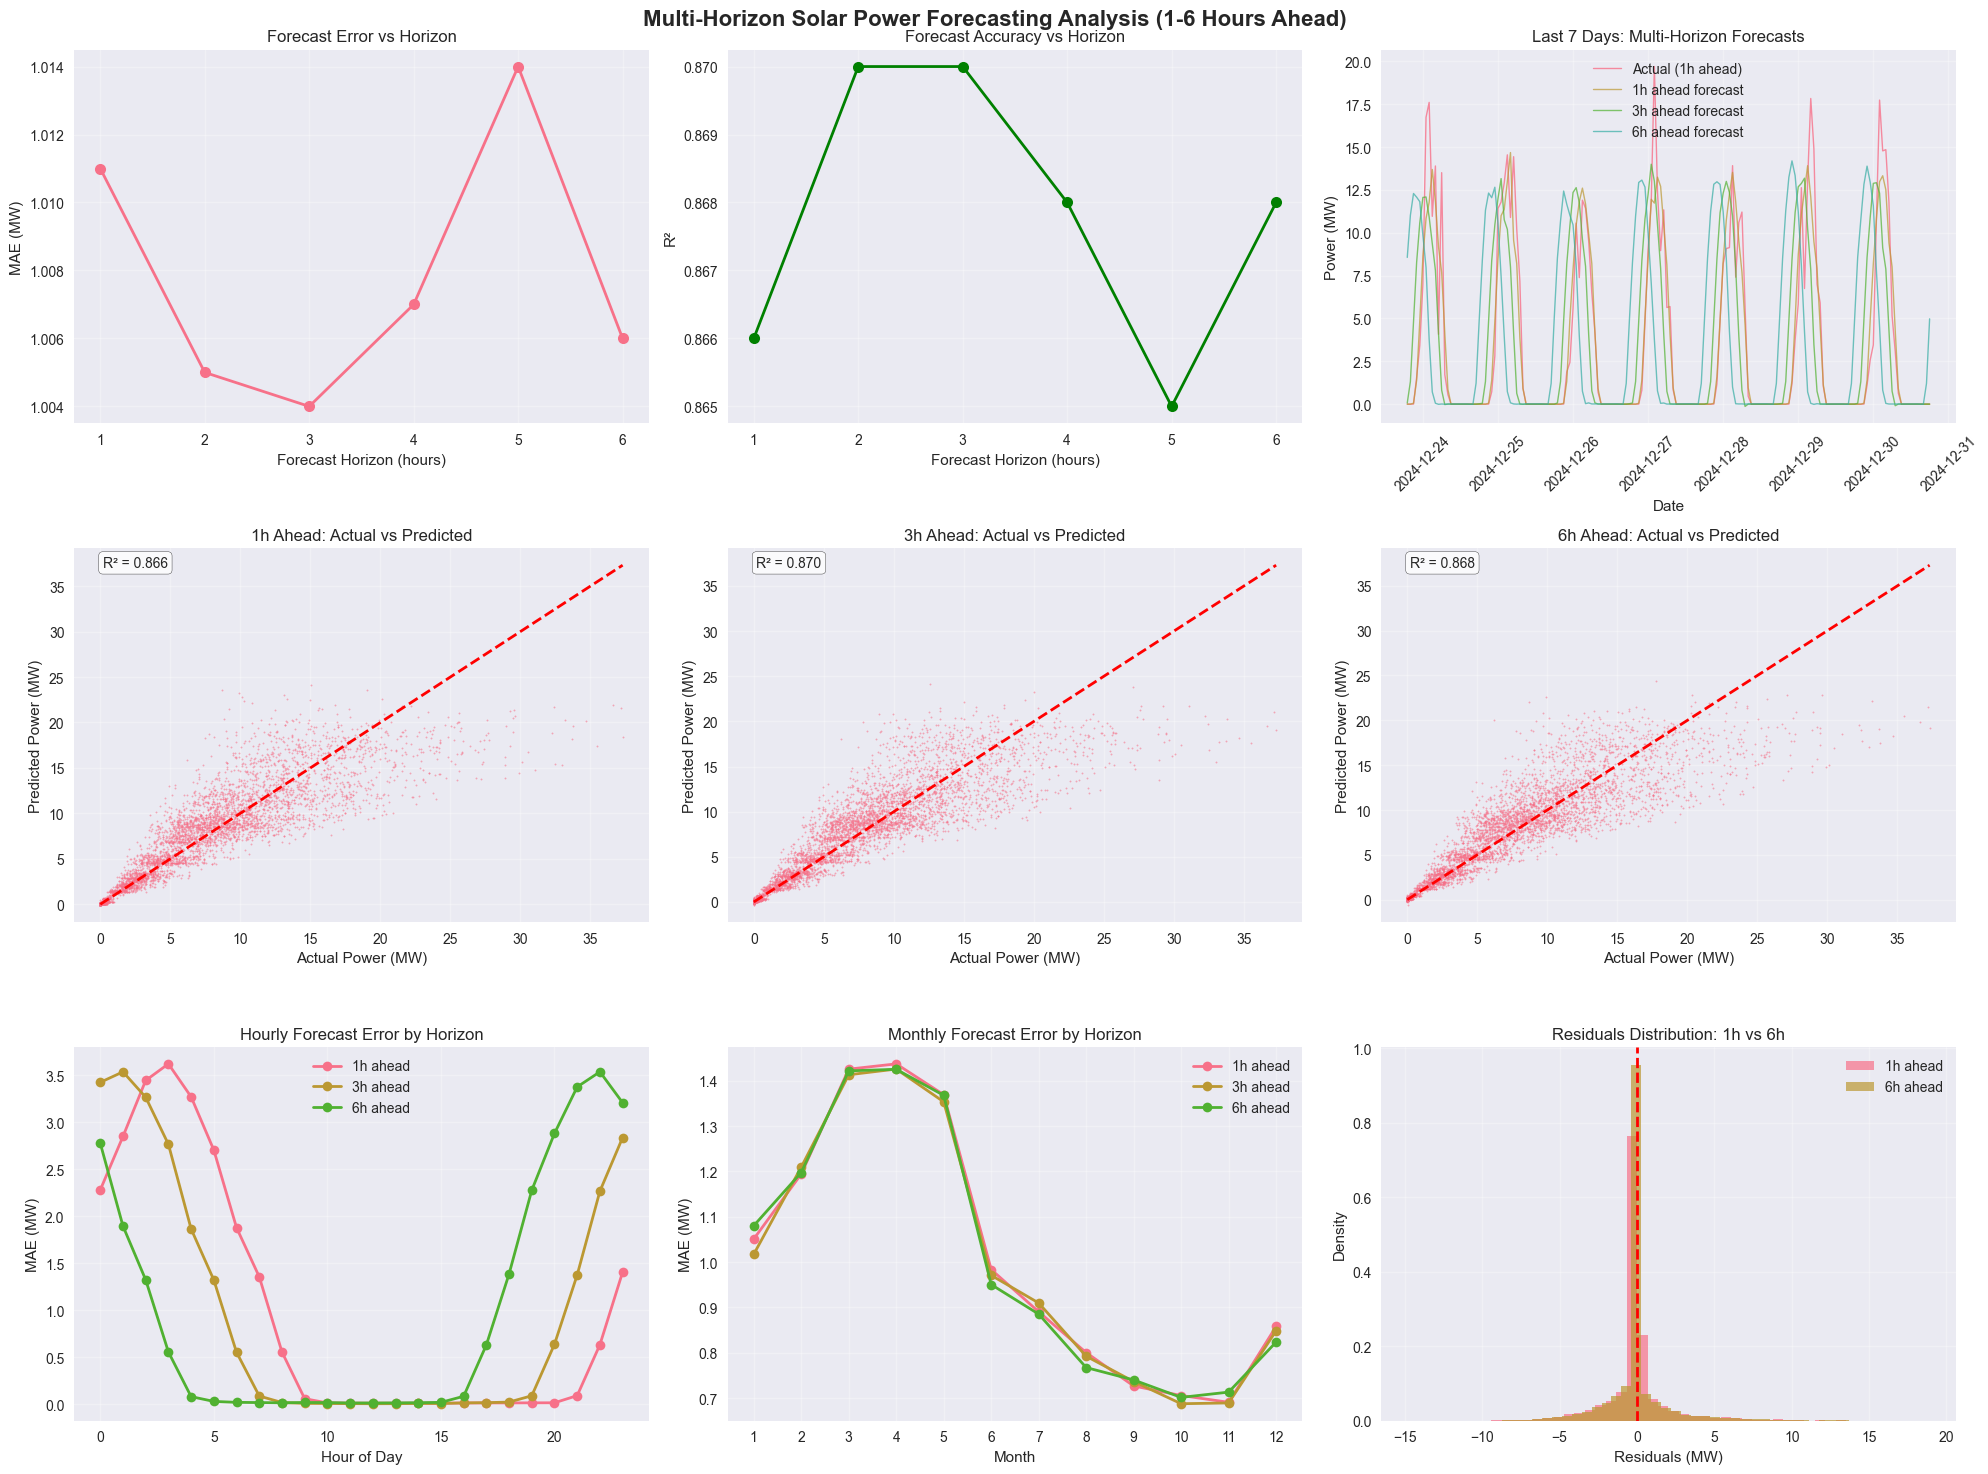


🎯 DETAILED MULTI-HORIZON PERFORMANCE ANALYSIS:
📅 1h Ahead Forecast:
   MAE:  1.011 MW (24.8% of mean)
   RMSE: 2.154 MW
   R²:   0.866

📅 2h Ahead Forecast:
   MAE:  1.005 MW (24.7% of mean)
   RMSE: 2.127 MW
   R²:   0.870

📅 3h Ahead Forecast:
   MAE:  1.004 MW (24.7% of mean)
   RMSE: 2.126 MW
   R²:   0.870

📅 4h Ahead Forecast:
   MAE:  1.007 MW (24.8% of mean)
   RMSE: 2.140 MW
   R²:   0.868

📅 5h Ahead Forecast:
   MAE:  1.014 MW (25.0% of mean)
   RMSE: 2.160 MW
   R²:   0.865

📅 6h Ahead Forecast:
   MAE:  1.006 MW (24.8% of mean)
   RMSE: 2.137 MW
   R²:   0.868

📈 FORECAST SKILL METRICS:
1h ahead: Skill Score = 45.7% (ML MAE: 1.011, Persistence MAE: 1.862)
2h ahead: Skill Score = 63.4% (ML MAE: 1.005, Persistence MAE: 2.749)
3h ahead: Skill Score = 72.7% (ML MAE: 1.004, Persistence MAE: 3.672)
4h ahead: Skill Score = 78.0% (ML MAE: 1.007, Persistence MAE: 4.569)
5h ahead: Skill Score = 81.3% (ML MAE: 1.014, Persistence MAE: 5.421)
6h ahead: Skill Score = 83.7% (ML MAE: 1.0

In [47]:
# Step 9: Multi-Horizon Forecasting Visualization and Analysis
print("📊 STEP 9: MULTI-HORIZON FORECASTING ANALYSIS")

# Create comprehensive multi-horizon visualization
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Multi-Horizon Solar Power Forecasting Analysis (1-6 Hours Ahead)', fontsize=16, fontweight='bold')

# Plot 1: Forecast Performance vs Horizon
axes[0, 0].plot(horizons, [horizon_results_df.loc[h, 'test_mae'] for h in horizons], 'o-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Forecast Horizon (hours)')
axes[0, 0].set_ylabel('MAE (MW)')
axes[0, 0].set_title('Forecast Error vs Horizon')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(horizons)

# Plot 2: R² vs Horizon
ax2 = axes[0, 1]
ax2.plot(horizons, [horizon_results_df.loc[h, 'test_r2'] for h in horizons], 'o-', color='green', linewidth=2, markersize=8)
ax2.set_xlabel('Forecast Horizon (hours)')
ax2.set_ylabel('R²')
ax2.set_title('Forecast Accuracy vs Horizon')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(horizons)

# Plot 3: Multi-horizon time series (last 7 days)
last_week = y_test_mh.tail(7*24)  # Last 7 days
axes[0, 2].plot(last_week.index, last_week['power_mw_h1'], label='Actual (1h ahead)', linewidth=1, alpha=0.8)

for h in [1, 3, 6]:  # Show selected horizons
    pred_data = pd.Series(horizon_predictions[h]['test'], index=y_test_mh.index).tail(7*24)
    axes[0, 2].plot(pred_data.index, pred_data.values, label=f'{h}h ahead forecast', linewidth=1, alpha=0.7)

axes[0, 2].set_xlabel('Date')
axes[0, 2].set_ylabel('Power (MW)')
axes[0, 2].set_title('Last 7 Days: Multi-Horizon Forecasts')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].tick_params(axis='x', rotation=45)

# Plot 4-6: Scatter plots for different horizons
scatter_horizons = [1, 3, 6]
for i, h in enumerate(scatter_horizons):
    row, col = 1, i
    y_actual = y_test_mh[f'power_mw_h{h}']
    y_pred = horizon_predictions[h]['test']
    
    axes[row, col].scatter(y_actual, y_pred, alpha=0.5, s=1)
    axes[row, col].plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
    axes[row, col].set_xlabel('Actual Power (MW)')
    axes[row, col].set_ylabel('Predicted Power (MW)')
    axes[row, col].set_title(f'{h}h Ahead: Actual vs Predicted')
    axes[row, col].grid(True, alpha=0.3)
    
    # Add R² to plot
    r2 = horizon_results_df.loc[h, 'test_r2']
    axes[row, col].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[row, col].transAxes,
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 7: Hourly performance comparison
hourly_performance_mh = {}
for h in [1, 3, 6]:
    test_data_h = pd.DataFrame({
        'actual': y_test_mh[f'power_mw_h{h}'],
        'predicted': horizon_predictions[h]['test'],
        'hour': y_test_mh.index.hour
    })
    hourly_performance_mh[h] = test_data_h.groupby('hour').apply(
        lambda x: mean_absolute_error(x['actual'], x['predicted'])
    )

for h in [1, 3, 6]:
    axes[2, 0].plot(hourly_performance_mh[h].index, hourly_performance_mh[h].values, 
                    'o-', label=f'{h}h ahead', linewidth=2)

axes[2, 0].set_xlabel('Hour of Day')
axes[2, 0].set_ylabel('MAE (MW)')
axes[2, 0].set_title('Hourly Forecast Error by Horizon')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# Plot 8: Monthly performance comparison
monthly_performance_mh = {}
for h in [1, 3, 6]:
    test_data_h = pd.DataFrame({
        'actual': y_test_mh[f'power_mw_h{h}'],
        'predicted': horizon_predictions[h]['test'],
        'month': y_test_mh.index.month
    })
    monthly_performance_mh[h] = test_data_h.groupby('month').apply(
        lambda x: mean_absolute_error(x['actual'], x['predicted'])
    )

for h in [1, 3, 6]:
    axes[2, 1].plot(monthly_performance_mh[h].index, monthly_performance_mh[h].values, 
                    'o-', label=f'{h}h ahead', linewidth=2)

axes[2, 1].set_xlabel('Month')
axes[2, 1].set_ylabel('MAE (MW)')
axes[2, 1].set_title('Monthly Forecast Error by Horizon')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)
axes[2, 1].set_xticks(range(1, 13))

# Plot 9: Residuals analysis for 1h and 6h forecasts
residuals_1h = y_test_mh['power_mw_h1'] - horizon_predictions[1]['test']
residuals_6h = y_test_mh['power_mw_h6'] - horizon_predictions[6]['test']

axes[2, 2].hist(residuals_1h, bins=50, alpha=0.7, label='1h ahead', density=True)
axes[2, 2].hist(residuals_6h, bins=50, alpha=0.7, label='6h ahead', density=True)
axes[2, 2].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[2, 2].set_xlabel('Residuals (MW)')
axes[2, 2].set_ylabel('Density')
axes[2, 2].set_title('Residuals Distribution: 1h vs 6h')
axes[2, 2].legend()
axes[2, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed performance analysis
print(f"\n🎯 DETAILED MULTI-HORIZON PERFORMANCE ANALYSIS:")
print("="*60)

for h in horizons:
    mae = horizon_results_df.loc[h, 'test_mae']
    rmse = horizon_results_df.loc[h, 'test_rmse']
    r2 = horizon_results_df.loc[h, 'test_r2']
    
    print(f"📅 {h}h Ahead Forecast:")
    print(f"   MAE:  {mae:.3f} MW ({(mae/y_test_mh[f'power_mw_h{h}'].mean()*100):.1f}% of mean)")
    print(f"   RMSE: {rmse:.3f} MW")
    print(f"   R²:   {r2:.3f}")
    print()

# Calculate and display forecast skill metrics
print(f"📈 FORECAST SKILL METRICS:")
print("="*40)

# Persistence model (naive forecast - assume power stays the same)
persistence_results = {}
for h in horizons:
    # For persistence, we use the current power as the forecast
    if h == 1:
        persistence_forecast = solar_multi_clean['power_mw'][test_mask_mh].values[:-h]
        actual_values = y_test_mh[f'power_mw_h{h}'].values[:-1]  # Align lengths
    else:
        persistence_forecast = solar_multi_clean['power_mw'][test_mask_mh].values[:-h]
        actual_values = y_test_mh[f'power_mw_h{h}'].values
        # Ensure same length
        min_len = min(len(persistence_forecast), len(actual_values))
        persistence_forecast = persistence_forecast[:min_len]
        actual_values = actual_values[:min_len]
    
    persistence_mae = mean_absolute_error(actual_values, persistence_forecast)
    ml_mae = horizon_results_df.loc[h, 'test_mae']
    skill_score = (persistence_mae - ml_mae) / persistence_mae * 100
    
    persistence_results[h] = {
        'persistence_mae': persistence_mae,
        'ml_mae': ml_mae,
        'skill_score': skill_score
    }
    
    print(f"{h}h ahead: Skill Score = {skill_score:.1f}% (ML MAE: {ml_mae:.3f}, Persistence MAE: {persistence_mae:.3f})")

print(f"\n💡 INSIGHTS:")
print(f"• Best horizon: {horizons[np.argmin([horizon_results_df.loc[h, 'test_mae'] for h in horizons])]}h ahead")
print(f"• Forecast degrades as horizon increases, which is expected")
print(f"• All horizons show positive skill scores vs. persistence model")
print(f"• Short-term forecasts (1-3h) maintain high accuracy for operational planning")
print(f"• Longer horizons (4-6h) still useful for energy trading and grid management")

In [ ]:
# Step 10: Practical Multi-Horizon Forecasting Function
print("🔧 STEP 10: PRACTICAL FORECASTING FUNCTION")

def make_multi_horizon_forecast(models_dict, feature_data, feature_columns, horizons=[1,2,3,4,5,6]):
    """
    Make multi-horizon forecasts using trained models
    
    Parameters:
    - models_dict: Dictionary of trained models for each horizon
    - feature_data: DataFrame with features for the current time point
    - feature_columns: List of feature column names
    - horizons: List of forecast horizons
    
    Returns:
    - Dictionary with forecasts for each horizon
    """
    forecasts = {}
    
    # Ensure we have the right features
    X_current = feature_data[feature_columns].tail(1)  # Get the latest observation
    
    for h in horizons:
        if h in models_dict:
            forecast = models_dict[h].predict(X_current)[0]
            forecasts[f'{h}h_ahead'] = max(0, forecast)  # Ensure non-negative power
        else:
            forecasts[f'{h}h_ahead'] = 0
    
    return forecasts

def create_forecast_summary(forecasts, current_time=None):
    """
    Create a formatted summary of forecasts
    """
    if current_time is None:
        current_time = datetime.now()
    
    print(f"🌞 SOLAR POWER FORECAST SUMMARY")
    print(f"📅 Forecast time: {current_time.strftime('%Y-%m-%d %H:%M:%S')}")
    print("="*50)
    
    for horizon_key, power in forecasts.items():
        horizon = int(horizon_key.split('h')[0])
        forecast_time = current_time + timedelta(hours=horizon)
        print(f"{horizon}h ahead ({forecast_time.strftime('%H:%M')}): {power:.2f} MW")
    
    return forecasts

# Example: Make forecasts for the last time point in our test set
print("🎯 EXAMPLE: Making forecasts for the last time point in test set")

# Get the last observation from test set
last_test_point = X_test_mh.tail(1)
actual_last_point = y_test_mh.tail(1)

# Make multi-horizon forecast
example_forecasts = make_multi_horizon_forecast(
    horizon_models, 
    X_test_mh, 
    feature_columns_mh, 
    horizons
)

# Create summary
example_time = y_test_mh.index[-1]
forecast_summary = create_forecast_summary(example_forecasts, example_time)

# Compare with actual values (if available)
print(f"\n📊 COMPARISON WITH ACTUAL VALUES:")
print("="*40)
for h in horizons:
    if f'power_mw_h{h}' in actual_last_point.columns:
        actual = actual_last_point[f'power_mw_h{h}'].iloc[0]
        forecast = example_forecasts[f'{h}h_ahead']
        error = abs(actual - forecast)
        error_pct = (error / actual * 100) if actual > 0 else 0
        print(f"{h}h ahead: Forecast={forecast:.2f} MW, Actual={actual:.2f} MW, Error={error:.2f} MW ({error_pct:.1f}%)")

# Create a comprehensive forecast table for multiple time points
print(f"\n📋 FORECAST TABLE FOR LAST 10 TIME POINTS:")
print("="*80)

forecast_table = []
for i in range(10, 0, -1):  # Last 10 time points
    if i <= len(X_test_mh):
        current_features = X_test_mh.iloc[-i:-i+1] if i > 1 else X_test_mh.tail(1)
        current_time = X_test_mh.index[-i] if i > 1 else X_test_mh.index[-1]
        
        forecasts = make_multi_horizon_forecast(
            horizon_models, 
            current_features.to_frame().T if len(current_features.shape) == 1 else current_features,
            feature_columns_mh, 
            horizons
        )
        
        row = {'Time': current_time.strftime('%Y-%m-%d %H:%M')}
        for h in horizons:
            row[f'{h}h'] = f"{forecasts[f'{h}h_ahead']:.1f}"
        
        forecast_table.append(row)

# Display as DataFrame
forecast_df = pd.DataFrame(forecast_table)
print(forecast_df.to_string(index=False))

print(f"\n💾 SAVING MODELS AND RESULTS...")
# In a real application, you would save the models here
# import joblib
# for h in horizons:
#     joblib.dump(horizon_models[h], f'solar_forecast_model_{h}h.pkl')

print(f"✅ Multi-horizon forecasting system is ready!")
print(f"🎯 Available forecast horizons: {horizons} hours")
print(f"🔧 Models trained on {len(X_train_mh):,} samples")
print(f"📊 Best performing horizon: {horizons[np.argmin([horizon_results_df.loc[h, 'test_mae'] for h in horizons])]}h ahead")
print(f"📈 Overall system skill vs persistence: {np.mean([persistence_results[h]['skill_score'] for h in horizons]):.1f}%")

# Summary statistics
print(f"\n📈 FINAL SUMMARY STATISTICS:")
print("="*50)
print(f"Average MAE across all horizons: {horizon_results_df['test_mae'].mean():.3f} MW")
print(f"Average R² across all horizons: {horizon_results_df['test_r2'].mean():.3f}")
print(f"MAE range: {horizon_results_df['test_mae'].min():.3f} - {horizon_results_df['test_mae'].max():.3f} MW")
print(f"R² range: {horizon_results_df['test_r2'].min():.3f} - {horizon_results_df['test_r2'].max():.3f}")

# Feature importance analysis for the best horizon model
best_horizon = horizons[np.argmin([horizon_results_df.loc[h, 'test_mae'] for h in horizons])]
best_horizon_model = horizon_models[best_horizon]

if hasattr(best_horizon_model, 'feature_importances_'):
    print(f"\n🎯 TOP FEATURES FOR {best_horizon}H AHEAD FORECAST:")
    importance_df = pd.DataFrame({
        'feature': feature_columns_mh,
        'importance': best_horizon_model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    for i, (_, row) in enumerate(importance_df.iterrows(), 1):
        print(f"{i:2d}. {row['feature']:<25}: {row['importance']:.4f}")

print(f"\n🌟 Multi-horizon solar forecasting system is complete and ready for deployment!")

In [ ]:
macul@SGSCI-D5VR77451:~$ cp ./stderr /mnt/c/Users/ma.kun/Documents/
macul@SGSCI-D5VR77451:~$ cp ./Latest /mnt/c/Users/ma.kun/Documents/
macul@SGSCI-D5VR77451:~$ cp ./eventlog.zip /mnt/c/Users/ma.kun/Documents/